In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
import time

In [3]:
data = pd.read_csv('BTCUSD.csv')
data = data.drop(['MA_daily','RSI','BB_High','BB_Low','BBW','MACD','Breakout','MA_weekly'], axis =1).dropna()
data

,time,open,high,low,close,tick_volume,RSI_signal,BB_signal,MACD_signal,MA_signal,Engulfing,Consolidation,ATR
13,2017-03-30 07:00:00,1041.353,1041.448,1041.350,1041.372,43,0,0,0,0,0,0,1.319143
14,2017-03-30 08:00:00,1041.226,1041.233,1040.308,1040.312,26,0,0,0,0,0,0,1.388000
15,2017-03-30 09:00:00,1040.269,1046.200,1040.269,1040.269,4,0,0,0,0,0,0,1.700357
16,2017-03-31 05:00:00,1047.531,1049.470,1042.917,1043.003,444,0,0,0,0,0,0,2.286143
17,2017-03-31 06:00:00,1043.003,1046.102,1042.000,1043.988,1025,0,0,0,0,0,0,2.508500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53629,2023-07-08 09:00:00,30260.738,30271.838,30209.738,30235.738,820,0,0,-1,-1,0,0,80.315071
53630,2023-07-08 10:00:00,30235.738,30240.938,30204.838,30209.338,573,0,0,-1,-1,0,0,76.079357
53631,2023-07-08 11:00:00,30209.338,30216.738,30141.638,30182.738,1043,0,0,-1,-1,0,0,75.150786
53632,2023-07-08 12:00:00,30184.038,30198.738,30131.338,30153.538,950,0,0,-1,-1,0,0,75.443643


In [11]:
# dates =list(data['time'])
# # plotting the data
# fig = figure(figsize=(25, 10), dpi=80)
# fig.patch.set_facecolor((1.0, 1.0, 1.0))
# plt.plot(dates, data['close'], color='b')
# xticks = [dates[i] if ((i%1500==0 and (len(dates)-i) > 10) or i==len(dates)-1) else None for i in range(len(dates))]
# x = np.arange(0,len(xticks))
# plt.xticks(x, xticks, rotation='vertical')
# plt.title("Daily close price for XAUUSD")
# plt.show()

TypeError: 'module' object is not subscriptable

In [32]:
# Remove the 'time' column as it is non-numeric
if 'time' in data.columns:
    data = data.drop(['time'], axis=1)

def create_sequences(input_data, target_data, seq_length):
    xs = []
    ys = []
    for i in range(len(input_data)-seq_length-1):
        x = input_data[i:(i+seq_length)]
        y = target_data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Separate features and target
X_train, y_train = train_data[:,:-1], train_data[:,-1]
X_test, y_test = test_data[:,:-1], test_data[:,-1]



In [33]:
X_train.shape

(42896, 11)

In [34]:
# Create sequences from training and test data
seq_length =64
X_train, y_train = create_sequences(X_train, y_train, seq_length)
X_test, y_test = create_sequences(X_test, y_test, seq_length)

# Convert to PyTorch tensors and create dataloaders
batch_size =512
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [35]:
class ForexPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(ForexPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.3
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
        self.reset_hidden_state(device)

    def reset_hidden_state(self, device):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred



In [17]:
# device agnostic code.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [36]:
# Set a seed for reproducibility
torch.manual_seed(42)

# Define device, model, loss function and optimizer
model = ForexPredictor(n_features=X_train.shape[2], n_hidden=512, seq_len=seq_length, n_layers=5)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Epoch 1/200, Loss: 0.0579
Epoch 2/200, Loss: 0.0146
Epoch 3/200, Loss: 0.0096
Epoch 4/200, Loss: 0.0089
Epoch 5/200, Loss: 0.0097
Epoch 6/200, Loss: 0.0085
Epoch 7/200, Loss: 0.0087
Epoch 8/200, Loss: 0.0081
Epoch 9/200, Loss: 0.0085
Epoch 10/200, Loss: 0.0096
Epoch 11/200, Loss: 0.0084
Epoch 12/200, Loss: 0.0080
Epoch 13/200, Loss: 0.0079
Epoch 14/200, Loss: 0.0080
Epoch 15/200, Loss: 0.0093
Epoch 16/200, Loss: 0.0076
Epoch 17/200, Loss: 0.0076
Epoch 18/200, Loss: 0.0075
Epoch 19/200, Loss: 0.0077
Epoch 20/200, Loss: 0.0070
Epoch 21/200, Loss: 0.0069
Epoch 22/200, Loss: 0.0067
Epoch 23/200, Loss: 0.0076
Epoch 24/200, Loss: 0.0081
Epoch 25/200, Loss: 0.0079
Epoch 26/200, Loss: 0.0080
Epoch 27/200, Loss: 0.0077
Epoch 28/200, Loss: 0.0079
Epoch 29/200, Loss: 0.0076
Epoch 30/200, Loss: 0.0073
Epoch 31/200, Loss: 0.0064
Epoch 32/200, Loss: 0.0062
Epoch 33/200, Loss: 0.0057
Epoch 34/200, Loss: 0.0045
Epoch 35/200, Loss: 0.0054
Epoch 36/200, Loss: 0.0045
Epoch 37/200, Loss: 0.0041
Epoch 38/2

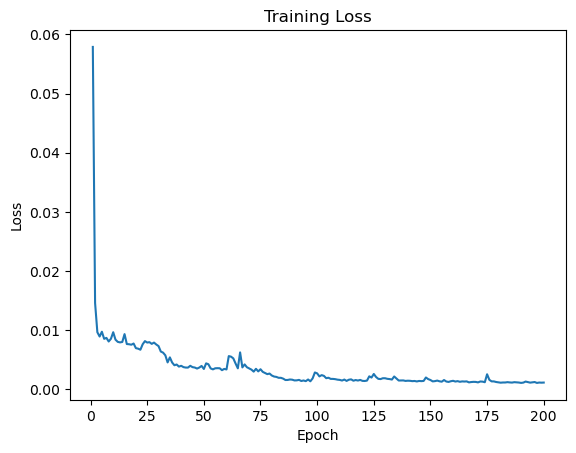

In [11]:
# Training the model
epochs = 100
model.train()
loss_values = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * inputs.size(0)
    
    epoch_loss /= len(train_loader.dataset)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Plotting the epoch-loss graph
plt.plot(range(1, epochs+1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Load and preprocess data
data = pd.read_csv('raw_btcusd.csv')
data['RSI'] = ta.rsi(data.close, length=15)
data['EMAF'] = ta.ema(data.close, length=20)
data['EMAM'] = ta.ema(data.close, length=100)
data['EMAS'] = ta.ema(data.close, length=150)
data['Target'] = data['close'] - data.open
data['Target'] = data['Target'].shift(-1)
data['TargetClass'] = [1 if data.Target[i] > 0 else 0 for i in range(len(data))]
data['TargetNextClose'] = data['close'].shift(-1)
data.dropna(inplace=True)
data.reset_index(inplace=True)

data.drop(['tick_volume', 'close', 'time'], axis=1, inplace=True)
data_set = data.iloc[:, 0:11]
sc = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = sc.fit_transform(data_set)


In [3]:
backcandles = 30
X = []

for j in range(8):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i - backcandles:i, j])

X = np.moveaxis(X, [0], [2])
yi = np.array(data_set_scaled[backcandles:, -1])
y = np.reshape(yi, (len(yi), 1))

splitlimit = int(len(X) * 0.8)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)



In [4]:
# Define the model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 8
hidden_size = 256
output_size = 1

model = LSTMModel(input_size, hidden_size, output_size)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())



In [6]:
# Training loop
num_epochs = 50
batch_size = 15

for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        targets = y_train_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')


Epoch [1/50], Loss: 0.000199
Epoch [2/50], Loss: 0.000015
Epoch [3/50], Loss: 0.000437
Epoch [4/50], Loss: 0.001509
Epoch [5/50], Loss: 0.001575
Epoch [6/50], Loss: 0.001269
Epoch [7/50], Loss: 0.001109
Epoch [8/50], Loss: 0.000948
Epoch [9/50], Loss: 0.000797
Epoch [10/50], Loss: 0.000665
Epoch [11/50], Loss: 0.000538
Epoch [12/50], Loss: 0.000417
Epoch [13/50], Loss: 0.000313
Epoch [14/50], Loss: 0.000230
Epoch [15/50], Loss: 0.000167
Epoch [16/50], Loss: 0.000122
Epoch [17/50], Loss: 0.000090
Epoch [18/50], Loss: 0.000068
Epoch [19/50], Loss: 0.000052
Epoch [20/50], Loss: 0.000041
Epoch [21/50], Loss: 0.000032
Epoch [22/50], Loss: 0.000024
Epoch [23/50], Loss: 0.000018
Epoch [24/50], Loss: 0.000013
Epoch [25/50], Loss: 0.000008
Epoch [26/50], Loss: 0.000006
Epoch [27/50], Loss: 0.000004
Epoch [28/50], Loss: 0.000003
Epoch [29/50], Loss: 0.000003
Epoch [30/50], Loss: 0.000004
Epoch [31/50], Loss: 0.000005
Epoch [32/50], Loss: 0.000007
Epoch [33/50], Loss: 0.000008
Epoch [34/50], Loss

In [7]:

# Save the trained model
torch.save(model.state_dict(), 'trained_pytorch_model.pth')


In [9]:
# Set the model to evaluation mode
model.eval()

# Perform forward pass to get predictions
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Convert the predictions tensor to a numpy array
y_pred = y_pred.numpy()

# Print the first 10 predicted values and actual values
for i in range(10):
    print(y_pred[i][0], y_test[i][0])


0.57956964 0.585246725004981
0.5816525 0.587193583659995
0.57910717 0.5855124152762063
0.5824022 0.5897357551348418
0.5799188 0.5967201007393628
0.585469 0.5985584983525024
0.5906507 0.5969012693677336
0.5942232 0.5953344616424198
0.5923226 0.5953670725884529
0.5901136 0.5959851537778796


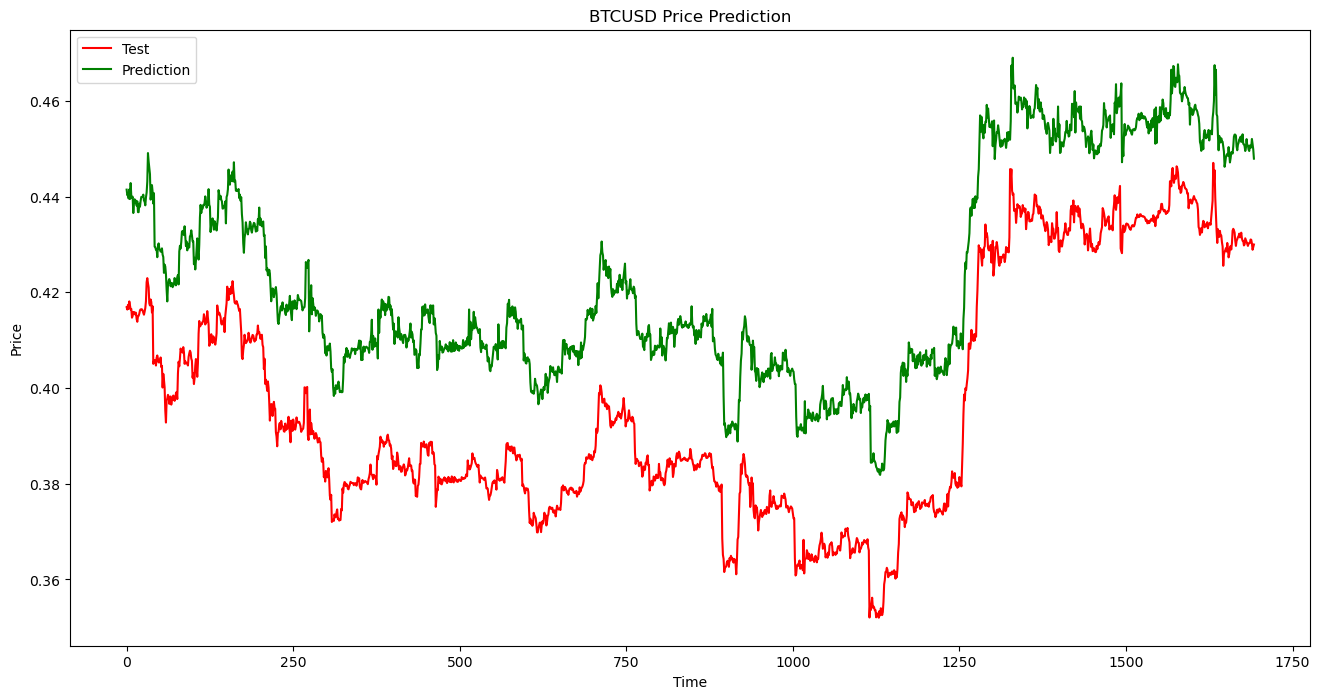

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(y_test[9000:], color='red', label='Test')
plt.plot(y_pred[9000:], color='green', label='Prediction')
plt.legend()
plt.title('BTCUSD Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()
